# **Coloration de Graphe avec Branch and Bound**

## **Introduction**

La coloration de graphe est un problème fondamental en informatique théorique et en optimisation combinatoire. L'objectif est d'attribuer un minimum de couleurs aux sommets d'un graphe tout en respectant la contrainte que deux sommets adjacents ne doivent pas avoir la même couleur.

### **Objectif du TP**

Ce projet se concentre sur l'implémentation de l'algorithme de coloration de graphe en utilisant Branch and Bound. Cette approche permet de limiter le nombre de configurations explorées grâce au mécanisme d'élagage (backtracking) pour accélérer le processus de recherche de solutions optimales.


## **Principe général de notre solution et explication de la fonction `optimized_graph_coloring`**


Notre implémentation de la coloration de graphe utilise la méthode Branch and Bound pour trouver le nombre minimal de couleurs nécessaires. Pour améliorer les performances, nous utilisons:
- Une approche itérative (non récursive) basée sur une pile
- Des mécanismes d'élagage (pruning) pour réduire l'espace de recherche

### 1. Initialisation et structures de données

- **Matrice d'adjacence**
- **Tableau de couleurs**: Un tableau qui associe à chaque sommet sa couleur (0 = non coloré)
- **Degrés des sommets**: Calcul du nombre de connexions pour chaque sommet
- **Ordre de traitement**: Les sommets sont ordonnés par degré décroissant pour traiter en priorité les sommets les plus contraints
- **Pile de backtracking**: Structure fondamentale pour mémoriser le parcours et permettre les retours en arrière

### 2. Mécanisme de backtracking avec la pile

La pile (stack) est l'élément clé qui permet d'implémenter le backtracking de manière efficace. Pour chaque sommet traité, nous stockons un triplet d'informations:

```
(index_sommet_dans_order, couleur_assignée, nombre_max_couleurs)
```

#### Comment fonctionne la relation parent-enfant dans la pile?

À tout moment dans l'algorithme:
- **Sommet courant**: Le sommet que nous essayons actuellement de colorer
- **Sommet de la pile**: Contient l'état du parent du sommet courant

Cette structure permet de naviguer dans l'arbre de décision:

1. Quand nous trouvons une couleur valide pour un sommet:
   - Nous sauvegardons son état dans la pile
   - Nous passons au sommet suivant (son enfant dans l'arbre de décision)

2. Quand nous ne pouvons pas colorer un sommet:
   - Nous revenons au sommet parent en dépilant la pile
   - Nous essayons une couleur différente pour ce parent

#### Exemple concret de backtracking

Considérons un petit graphe avec les sommets A, B, C où A est connecté à B et C:

1. Nous colorons A en rouge (couleur 1)
2. Nous empilons `(A, rouge, 1)`
3. Nous passons à B et le colorons en bleu (couleur 2)
4. Nous empilons `(B, bleu, 2)`
5. Nous passons à C, mais ne trouvons pas de couleur valide
6. Nous faisons un backtracking: dépilons `(B, bleu, 2)`
7. Nous effaçons la couleur de B et essayons une autre couleur
8. Si nous ne trouvons pas de solution, nous remontons encore à A, etc.

### 3. Conditions d'arrêt

Notre algorithme s'arrête dans les cas suivants:

1. **Solution complète trouvée**: Tous les sommets sont colorés
2. **Pile vide**: Toutes les possibilités ont été explorées
3. **Élagage**: Certaines branches sont abandonnées si le nombre de couleurs utilisées dépasse déjà la meilleure solution trouvée

### 4. Processus d'exploration pas à pas

1. **Initialisation**: Ordonnancement des sommets par degré décroissant
2. **Exploration**: Pour chaque sommet dans l'ordre établi:
   - Essayer chaque couleur possible (de 1 jusqu'à max_color+1)
   - Si une couleur valide est trouvée, colorer le sommet et passer au suivant
   - Sinon, faire un backtracking
3. **Backtracking**: En cas d'impasse
   - Récupérer l'état précédent depuis la pile
   - Essayer une couleur différente pour le sommet parent
4. **Mise à jour de la solution**: Quand une coloration complète est trouvée, la comparer avec la meilleure solution actuelle

## Conclusion

Notre implémentation combine plusieurs techniques avancées pour résoudre efficacement le problème de coloration de graphe:
- Structure de données optimisée pour le backtracking
- Stratégie d'élagage Branch and Bound

Cette approche permet d'explorer intelligemment l'espace des solutions possibles en minimisant le temps de calcul nécessaire pour trouver une coloration optimale.

L'algorithme a été testé sur plusieurs graphes avec différents nombres de sommets. Les performances observées sont résumées dans le tableau suivant :


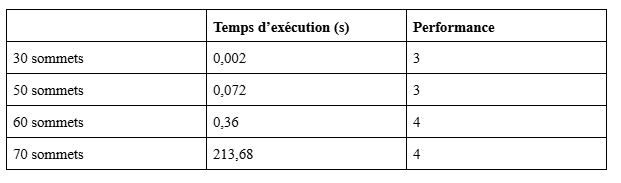

## **Importation des bibliothèques nécessaires**


In [ ]:
import time
import numpy as np
from google.colab import files
import io
import matplotlib.pyplot as plt
import networkx as nx
import random

## **Lecture d'un fichier COL et création de la matrice d'adjacence**


In [ ]:
def read_col_file(file_content):
    """
    Lire un contenu de fichier au format COL et extraire le graphe.
    Retourne une matrice d'adjacence.
    """
    edges = []
    vertices = set()
    n_vertices = 0

    lines = file_content.splitlines()

    for line in lines:
        if line.startswith('e '):
            _, v1, v2 = line.strip().split()
            v1, v2 = int(v1), int(v2)
            edges.append((v1, v2))
            vertices.add(v1)
            vertices.add(v2)
        elif line.startswith('p '):
            parts = line.strip().split()
            n_vertices = int(parts[2])
            n_edges = int(parts[3])

    # Créer la matrice d'adjacence
    if n_vertices == 0:
        n_vertices = max(vertices)

    adj_matrix = np.zeros((n_vertices, n_vertices), dtype=int)

    for v1, v2 in edges:
        adj_matrix[v1-1][v2-1] = 1
        adj_matrix[v2-1][v1-1] = 1  # Graphe non orienté

    return adj_matrix, n_vertices, edges

## **Visualisation du graphe et de sa coloration**


In [ ]:
def visualize_graph_coloring(edges, n_vertices, colors, max_color):
    """
    Visualiser le graphe avec sa coloration.
    """
    # Créer le graphe
    G = nx.Graph()

    # Ajouter les sommets
    for i in range(n_vertices):
        G.add_node(i+1)  # +1 car l'indexation commence à 1 dans les fichiers COL

    # Ajouter les arêtes
    for v1, v2 in edges:
        G.add_edge(v1, v2)

    # Définir une palette de couleurs distinctes
    color_map = plt.cm.get_cmap('tab20', max_color)
    node_colors = [color_map(colors[i-1] - 1) for i in G.nodes()]

    # Positionner les sommets
    if n_vertices <= 100:
        # Pour les petits graphes, utiliser un algorithme de force
        pos = nx.spring_layout(G, seed=42)
    else:
        # Pour les grands graphes, utiliser une disposition circulaire
        pos = nx.circular_layout(G)

    plt.figure(figsize=(12, 10))

    # Dessiner le graphe
    nx.draw(G, pos, with_labels=True, node_color=node_colors,
            node_size=500, font_size=10, font_weight='bold',
            edge_color='gray', width=1.0, alpha=0.9)

    # Ajouter une légende pour les couleurs
    color_legends = []
    for i in range(1, max_color+1):
        color_legends.append(plt.Line2D([0], [0], marker='o', color='w',
                             markerfacecolor=color_map(i-1), markersize=15,
                             label=f'Couleur {i}'))
    plt.legend(handles=color_legends, loc='upper right')

    plt.title(f'Coloration du graphe ({n_vertices} sommets, {max_color} couleurs)')
    plt.axis('off')
    plt.tight_layout()
    plt.savefig('colored_graph.png', dpi=300, bbox_inches='tight')
    plt.show()

## **Vérification de la validité d'une coloration**

Cette fonction vérifie si une couleur attribuée à un sommet est valide en s'assurant qu'aucun de ses voisins immédiats n'a déjà la même couleur. Elle est utilisée dans les algorithmes de coloration de graphes pour garantir une attribution correcte des couleurs.


In [ ]:
def is_valid_coloring(graph, colors, vertex, color):
    """
    Vérifie si la couleur est valide pour le sommet
    en tenant compte des sommets adjacents déjà colorés.
    """
    for i in range(len(graph)):
        if graph[vertex][i] == 1 and colors[i] == color:
            return False
    return True

# Explication de la fonction `optimized_graph_coloring`

La fonction `optimized_graph_coloring(graph, n_vertices)` vise à résoudre le problème de coloration de graphe en minimisant le nombre de couleurs utilisées. Elle implémente une approche optimisée utilisant une stratégie de **Branch and Bound** ainsi qu'une **heuristique de tri des sommets** pour réduire l'espace de recherche.

## 1. Initialisation des structures de données

- **Couleurs des sommets** : Initialisées à `0` (non colorés).
- **Degrés des sommets** : Calculés pour chaque sommet en comptant ses connexions.
- **Ordre des sommets** : Triés par degré décroissant afin de commencer par les sommets les plus contraints.
- **Pile** : Utilisée pour mémoriser l'état actuel de la recherche (évitant la récursivité).
- **Bornes** :
  - **Supérieure** : Définie par le nombre maximal de couleurs trouvées jusqu'à présent.
  - **Inférieure** : Fixée à `max(degrees) + 1`.

## 2. Exploration des colorations possibles

L'algorithme fonctionne selon une **approche itérative avec une pile**:

1. Si tous les sommets sont coloriés, on vérifie si la solution est meilleure que la meilleure trouvée jusqu'alors. Si oui, elle est sauvegardée.
2. Si la solution actuelle dépasse la meilleure trouvée (élagage), on effectue un retour en arrière.
3. Sinon, on tente d'attribuer une couleur valide au sommet courant en respectant les contraintes d'adjacence.
4. Si une couleur valide est trouvée, on avance au sommet suivant et empile l'état actuel.
5. Si aucune couleur n'est possible, on dépile et on revient à l'étape précédente pour essayer une autre couleur.

## 3. Gestion de la pile

La pile stocke les états sous la forme `(index_sommet_dans_order, couleur, max_color)`, permettant de revenir en arrière lorsque nécessaire. Lorsqu'un sommet ne peut pas être coloré avec les options actuelles, on dépile et on tente la couleur suivante.




In [ ]:
def optimized_graph_coloring(graph, n_vertices):
    """
    Version optimisée de la coloration de graphe avec Branch and Bound.
    Utilise l'élagage et des heuristiques pour améliorer les performances.
    """
    start_time = time.time()

    # Initialiser les couleurs (0 = non coloré)
    colors = [0] * n_vertices

    # Calculer le degré de chaque sommet pour ordonner les sommets
    degrees = [sum(graph[i]) for i in range(n_vertices)]

    # Ordonner les sommets par degré décroissant (heuristique)
    # Les sommets avec plus de connexions sont plus contraints, donc les traiter en premier
    vertex_order = sorted(range(n_vertices), key=lambda i: degrees[i], reverse=True)

    # Pile pour remplacer la récursivité - stocke (index_sommet_dans_order, couleur, max_color)
    stack = []

    current_idx = 0  # Index dans vertex_order
    current_color = 1
    max_color = 1

    # Bornes supérieures et inférieures pour l'élagage
    # Une borne inférieure simple est le degré max + 1
    lower_bound = max(degrees) + 1

    # Stockage pour la meilleure solution trouvée
    best_coloring = None
    best_color_count = float('inf')

    while current_idx >= 0:
        if current_idx >= n_vertices:
            # Solution complète trouvée
            if max_color < best_color_count:
                best_color_count = max_color
                best_coloring = colors.copy()

            # Retour arrière pour chercher de meilleures solutions
            if stack:
                current_idx, current_color, max_color = stack.pop()
                current_vertex = vertex_order[current_idx]
                colors[current_vertex] = 0  # Effacer la coloration
                current_color += 1  # Essayer la couleur suivante
            else:
                break
            continue

        # Sommet actuel dans l'ordre heuristique
        current_vertex = vertex_order[current_idx]

        # Élagage: si la couleur actuelle atteint déjà la meilleure solution, inutile de continuer
        if max_color >= best_color_count:
            # Retour arrière
            if stack:
                current_idx, current_color, max_color = stack.pop()
                current_vertex = vertex_order[current_idx]
                colors[current_vertex] = 0
                current_color += 1
            else:
                break
            continue

        # Chercher une couleur valide
        valid_color_found = False

        while current_color <= max_color + 1:
            if is_valid_coloring(graph, colors, current_vertex, current_color):
                valid_color_found = True
                break
            current_color += 1

        if valid_color_found:
            # Mettre à jour la couleur maximale si nécessaire
            new_max_color = max(max_color, current_color)

            # Colorer le sommet
            colors[current_vertex] = current_color

            # Sauvegarder l'état et avancer
            stack.append((current_idx, current_color, max_color))
            current_idx += 1
            max_color = new_max_color
            current_color = 1  # Réinitialiser pour le prochain sommet
        else:
            # Retour arrière
            if stack:
                current_idx, current_color, max_color = stack.pop()
                current_vertex = vertex_order[current_idx]
                colors[current_vertex] = 0
                current_color += 1
            else:
                break

    # Vérifier si une solution a été trouvée
    if best_coloring is None:
        print("Aucune solution n'a été trouvée.")
        return None, 0, 0

    # Calculer le temps d'exécution
    execution_time = time.time() - start_time

    # Afficher les résultats
    print(f"Nombre de couleurs utilisées: {best_color_count}")
    print(f"Temps d'exécution: {execution_time:.6f} secondes")
    print("Coloration trouvée:", best_coloring)

    return best_coloring, best_color_count, execution_time

## **Fonction principale : Chargement et exécution**

Cette fonction permet de :
1. **Charger un fichier COL** contenant un graphe.
2. **Extraire la matrice d’adjacence** et les arêtes.
3. **Exécuter l’algorithme de coloration optimisé** avec Branch and Bound.
4. **Visualiser le graphe coloré** si une solution est trouvée.
5. **Sauvegarder les résultats** (nombre de couleurs, temps d'exécution, affectation des couleurs) dans un fichier `resultats_coloration.txt`.

L'exécution commence lorsque le script est lancé.

=== Coloration de graphe avec Branch and Bound optimisé ===
Veuillez télécharger votre fichier COL...


Saving dsjc125_30.col to dsjc125_30.col
Fichier téléchargé: dsjc125_30.col
Graphe extrait avec 30 sommets

Exécution de l'algorithme optimisé avec élagage...
Nombre de couleurs utilisées: 3
Temps d'exécution: 0.002994 secondes
Coloration trouvée: [2, 1, 1, 2, 1, 2, 1, 1, 1, 1, 3, 1, 2, 3, 3, 2, 2, 2, 2, 1, 2, 1, 1, 1, 2, 1, 3, 3, 3, 2]

Visualisation du graphe coloré...


<ipython-input-3-8eba2f34700f>:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_map = plt.cm.get_cmap('tab20', max_color)
<ipython-input-3-8eba2f34700f>:45: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


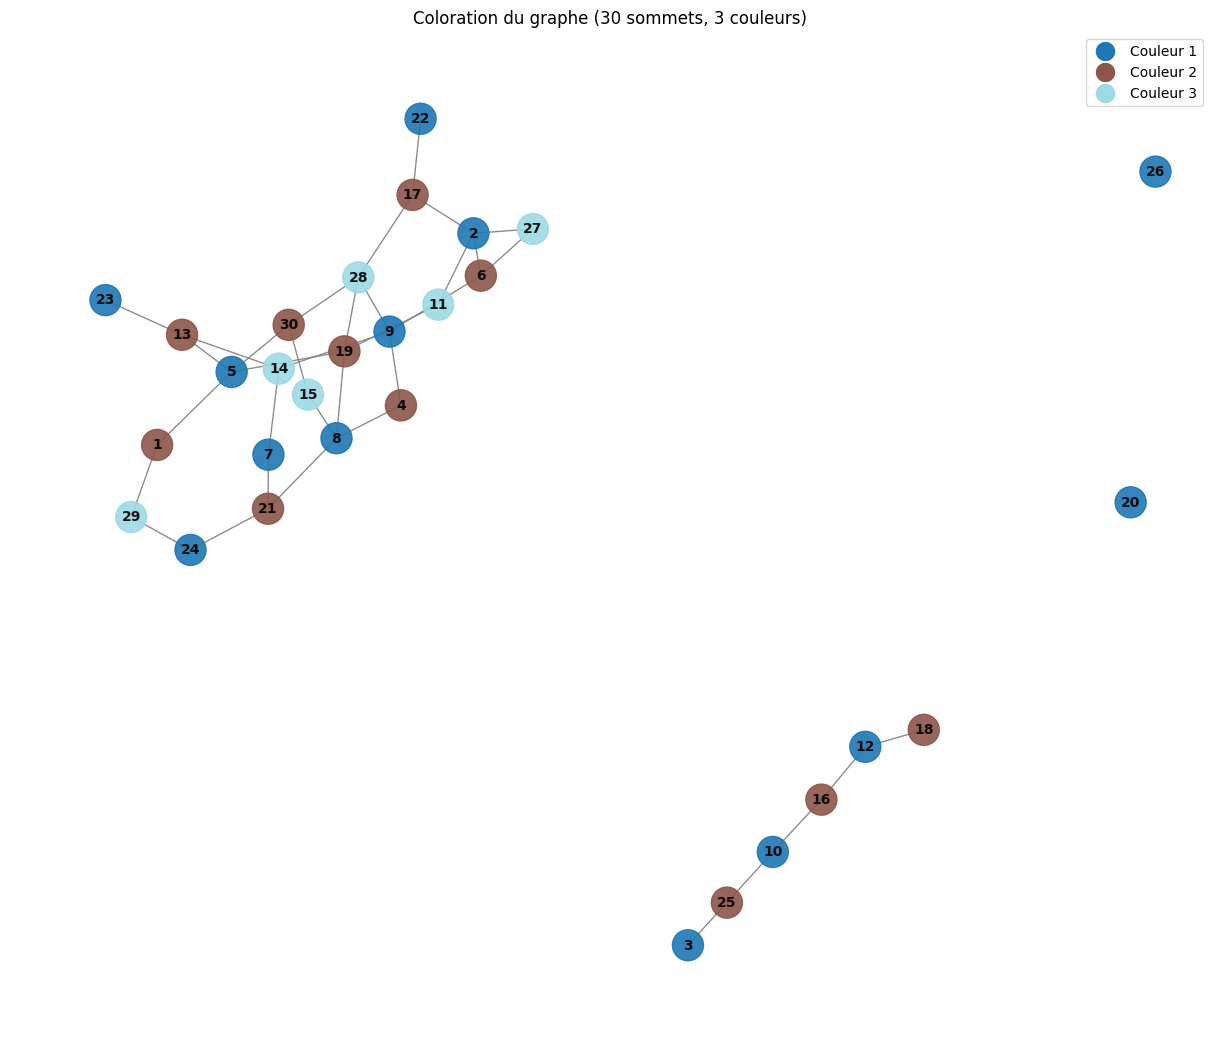


Les résultats ont été sauvegardés dans 'resultats_coloration.txt'


In [ ]:
# Fonction principale
def main():
    print("=== Coloration de graphe avec Branch and Bound optimisé ===")
    print("Veuillez télécharger votre fichier COL...")

    # Utiliser files.upload() de Google Colab
    uploaded = files.upload()

    # Traiter le premier fichier téléchargé
    if uploaded:
        file_name = next(iter(uploaded))
        file_content = uploaded[file_name].decode('utf-8')

        print(f"Fichier téléchargé: {file_name}")

        # Extraire le graphe
        graph, n_vertices, edges = read_col_file(file_content)
        print(f"Graphe extrait avec {n_vertices} sommets")

        print("\nExécution de l'algorithme optimisé avec élagage...")
        colors, max_color, execution_time = optimized_graph_coloring(graph, n_vertices)

        # Visualiser le graphe coloré si une solution a été trouvée
        if colors is not None:
            print("\nVisualisation du graphe coloré...")
            visualize_graph_coloring(edges, n_vertices, colors, max_color)

            # Sauvegarder les résultats
            with open('resultats_coloration.txt', 'w') as f:
                f.write(f"Fichier: {file_name}\n")
                f.write(f"Nombre de sommets: {n_vertices}\n")
                f.write(f"Nombre de couleurs utilisées: {max_color}\n")
                f.write(f"Temps d'exécution: {execution_time:.6f} secondes\n")
                f.write(f"Coloration: {colors}\n")

            print("\nLes résultats ont été sauvegardés dans 'resultats_coloration.txt'")
    else:
        print("Aucun fichier n'a été téléchargé.")

if __name__ == "__main__":
    main()